In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_075_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                  activation='relu')) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))         
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_075_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 5333, 64)          12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5333, 64)          12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7243 - acc: 0.0843
Epoch 00001: val_loss improved from inf to 2.72225, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_3_conv_checkpoint/001-2.7223.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 2.7243 - acc: 0.0843 - val_loss: 2.7223 - val_acc: 0.0818
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6999 - acc: 0.1013
Epoch 00002: val_loss improved from 2.72225 to 2.65173, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_3_conv_checkpoint/002-2.6517.hdf5
36805/36805 [==============================] - 80s 2ms/sample - loss: 2.6999 - acc: 0.1013 - val_loss: 2.6517 - val_acc: 0.1200
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3222 - acc: 0.2457
Epoch 00003: val_loss improved from 2.6

36800/36805 [============================>.] - ETA: 0s - loss: 0.2617 - acc: 0.9160
Epoch 00027: val_loss did not improve from 1.10654
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2616 - acc: 0.9160 - val_loss: 1.3096 - val_acc: 0.6993
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2686 - acc: 0.9148
Epoch 00028: val_loss did not improve from 1.10654
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2687 - acc: 0.9147 - val_loss: 1.3252 - val_acc: 0.6562
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2759 - acc: 0.9108
Epoch 00029: val_loss did not improve from 1.10654
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2759 - acc: 0.9108 - val_loss: 1.2747 - val_acc: 0.7049
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2462 - acc: 0.9208
Epoch 00030: val_loss did not improve from 1.10654
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1608 - acc: 0.9503
Epoch 00057: val_loss did not improve from 1.10654
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.1608 - acc: 0.9503 - val_loss: 1.3546 - val_acc: 0.7191

1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_3_conv Model


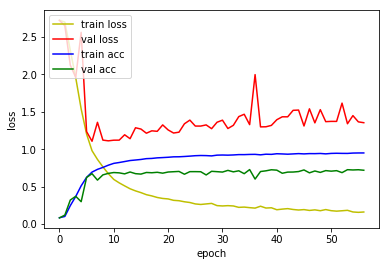

4815/4815 [==============================] - 4s 884us/sample - loss: 1.2714 - acc: 0.6195
Loss: 1.2713904990833 Accuracy: 0.61952233

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6080 - acc: 0.1365
Epoch 00001: val_loss improved from inf to 2.21475, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_4_conv_checkpoint/001-2.2148.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 2.6079 - acc: 0.1365 - val_loss: 2.2148 - val_acc: 0.3035
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9484 - acc: 0.3576
Epoch 00002: val_loss improved from 2.21475 to 2.10194, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_4_conv_checkpoint/002-2.1019.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.9484 - acc: 0.3576 - val_loss: 2.1019 - val_acc: 0.2718
Epoch 3/500
36800/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.3757 - acc: 0.8798
Epoch 00026: val_loss did not improve from 0.63952
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.3758 - acc: 0.8798 - val_loss: 0.7147 - val_acc: 0.7971
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3602 - acc: 0.8838
Epoch 00027: val_loss did not improve from 0.63952
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.3601 - acc: 0.8838 - val_loss: 0.6724 - val_acc: 0.8304
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3388 - acc: 0.8896
Epoch 00028: val_loss did not improve from 0.63952
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.3387 - acc: 0.8897 - val_loss: 0.6886 - val_acc: 0.8311
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3491 - acc: 0.8865
Epoch 00029: val_loss did not improve from 0.63952
36805/36805 [========================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2576 - acc: 0.9154
Epoch 00056: val_loss did not improve from 0.63952
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2576 - acc: 0.9154 - val_loss: 0.6970 - val_acc: 0.8190
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2554 - acc: 0.9161
Epoch 00057: val_loss did not improve from 0.63952
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2553 - acc: 0.9161 - val_loss: 0.7211 - val_acc: 0.8269
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2468 - acc: 0.9203
Epoch 00058: val_loss did not improve from 0.63952
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2468 - acc: 0.9203 - val_loss: 0.8021 - val_acc: 0.8204
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2438 - acc: 0.9216
Epoch 00059: val_loss did not improve from 0.63952
36805/36805 [===========

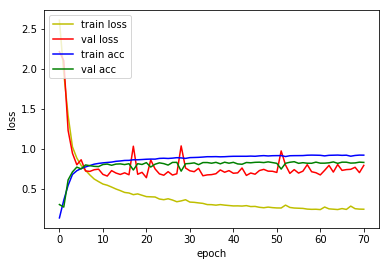

4815/4815 [==============================] - 4s 924us/sample - loss: 0.7915 - acc: 0.7801
Loss: 0.7915258266225164 Accuracy: 0.7800623

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5330 - acc: 0.1623
Epoch 00001: val_loss improved from inf to 2.17938, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_5_conv_checkpoint/001-2.1794.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 2.5328 - acc: 0.1624 - val_loss: 2.1794 - val_acc: 0.3149
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7903 - acc: 0.4087
Epoch 00002: val_loss improved from 2.17938 to 1.72044, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_5_conv_checkpoint/002-1.7204.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 1.7903 - acc: 0.4087 - val_loss: 1.7204 - val_acc: 0.4449
Epoch 3/500
36800/36805 [======================

36800/36805 [============================>.] - ETA: 0s - loss: 0.3741 - acc: 0.8803
Epoch 00025: val_loss did not improve from 0.44659
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3740 - acc: 0.8803 - val_loss: 0.5895 - val_acc: 0.8607
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3761 - acc: 0.8809
Epoch 00026: val_loss did not improve from 0.44659
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3761 - acc: 0.8809 - val_loss: 0.5388 - val_acc: 0.8498
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3622 - acc: 0.8860
Epoch 00027: val_loss did not improve from 0.44659
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3621 - acc: 0.8860 - val_loss: 0.5028 - val_acc: 0.8600
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3535 - acc: 0.8899
Epoch 00028: val_loss did not improve from 0.44659
36805/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2706 - acc: 0.9120
Epoch 00054: val_loss did not improve from 0.44654
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2708 - acc: 0.9120 - val_loss: 0.5543 - val_acc: 0.8588
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2730 - acc: 0.9128
Epoch 00055: val_loss did not improve from 0.44654
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2733 - acc: 0.9128 - val_loss: 0.6262 - val_acc: 0.8246
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2747 - acc: 0.9104
Epoch 00056: val_loss did not improve from 0.44654
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2747 - acc: 0.9104 - val_loss: 0.4982 - val_acc: 0.8810
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2627 - acc: 0.9157
Epoch 00057: val_loss did not improve from 0.44654
36805/36805 [========================

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2127 - acc: 0.9312
Epoch 00083: val_loss did not improve from 0.43709
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2126 - acc: 0.9312 - val_loss: 0.4642 - val_acc: 0.8905
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2115 - acc: 0.9300
Epoch 00084: val_loss did not improve from 0.43709
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2115 - acc: 0.9300 - val_loss: 0.4520 - val_acc: 0.8901
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2080 - acc: 0.9342
Epoch 00085: val_loss did not improve from 0.43709
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2080 - acc: 0.9342 - val_loss: 0.4649 - val_acc: 0.8915
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2153 - acc: 0.9305
Epoch 00086: val_loss did not improve from 0.43709
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1968 - acc: 0.9363
Epoch 00112: val_loss did not improve from 0.42642
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1968 - acc: 0.9363 - val_loss: 0.4855 - val_acc: 0.8863
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2020 - acc: 0.9333
Epoch 00113: val_loss did not improve from 0.42642
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2020 - acc: 0.9333 - val_loss: 0.5576 - val_acc: 0.8803
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2230 - acc: 0.9276
Epoch 00114: val_loss did not improve from 0.42642
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2230 - acc: 0.9276 - val_loss: 0.5035 - val_acc: 0.8668
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2354 - acc: 0.9248
Epoch 00115: val_loss did not improve from 0.42642
36805/36805 [=====================

Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1761 - acc: 0.9429
Epoch 00142: val_loss did not improve from 0.42642
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1761 - acc: 0.9429 - val_loss: 0.4880 - val_acc: 0.8889

1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_5_conv Model


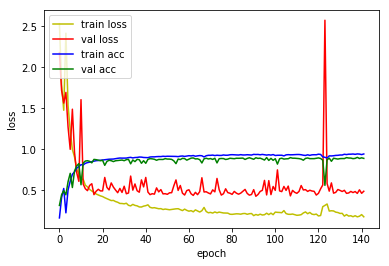

4815/4815 [==============================] - 4s 921us/sample - loss: 0.5926 - acc: 0.8594
Loss: 0.592554632711262 Accuracy: 0.8593977

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7265 - acc: 0.0793
Epoch 00001: val_loss improved from inf to 2.71882, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_6_conv_checkpoint/001-2.7188.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 2.7264 - acc: 0.0793 - val_loss: 2.7188 - val_acc: 0.0818
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7229 - acc: 0.0787
Epoch 00002: val_loss did not improve from 2.71882
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7229 - acc: 0.0787 - val_loss: 2.7197 - val_acc: 0.0820
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7219 - acc: 0.0794
Epoch 00003: val_loss did not improve from 2.71882
36805/36805 

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0817
Epoch 00029: val_loss did not improve from 2.71830
36805/36805 [==============================] - 87s 2ms/sample - loss: 2.7205 - acc: 0.0817 - val_loss: 2.7184 - val_acc: 0.0820
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0793
Epoch 00030: val_loss did not improve from 2.71830
36805/36805 [==============================] - 87s 2ms/sample - loss: 2.7205 - acc: 0.0793 - val_loss: 2.7189 - val_acc: 0.0785
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7206 - acc: 0.0796
Epoch 00031: val_loss did not improve from 2.71830
36805/36805 [==============================] - 87s 2ms/sample - loss: 2.7206 - acc: 0.0796 - val_loss: 2.7185 - val_acc: 0.0820
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0804
Epoch 00032: val_loss did not improve from 2.71830
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0812
Epoch 00058: val_loss did not improve from 2.71820
36805/36805 [==============================] - 87s 2ms/sample - loss: 2.7205 - acc: 0.0812 - val_loss: 2.7187 - val_acc: 0.0785
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0793
Epoch 00059: val_loss did not improve from 2.71820
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7205 - acc: 0.0794 - val_loss: 2.7186 - val_acc: 0.0785
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0791
Epoch 00060: val_loss did not improve from 2.71820
36805/36805 [==============================] - 87s 2ms/sample - loss: 2.7205 - acc: 0.0791 - val_loss: 2.7185 - val_acc: 0.0785
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0819
Epoch 00061: val_loss did not improve from 2.71820
36805/36805 [========================

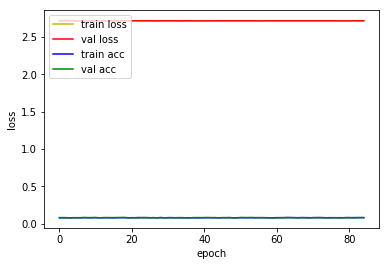

4815/4815 [==============================] - 5s 953us/sample - loss: 2.7130 - acc: 0.0781
Loss: 2.7129934609493365 Accuracy: 0.078089304

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7278 - acc: 0.0767
Epoch 00001: val_loss improved from inf to 2.71843, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_7_conv_checkpoint/001-2.7184.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 2.7278 - acc: 0.0766 - val_loss: 2.7184 - val_acc: 0.0820
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7223 - acc: 0.0794
Epoch 00002: val_loss did not improve from 2.71843
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7223 - acc: 0.0794 - val_loss: 2.7190 - val_acc: 0.0785
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7217 - acc: 0.0799
Epoch 00003: val_loss did not improve from 2.71843
36805/368

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2210 - acc: 0.9318
Epoch 00025: val_loss did not improve from 0.18163
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2210 - acc: 0.9317 - val_loss: 0.2374 - val_acc: 0.9366
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2206 - acc: 0.9303
Epoch 00026: val_loss improved from 0.18163 to 0.17261, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_7_conv_checkpoint/026-0.1726.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2206 - acc: 0.9303 - val_loss: 0.1726 - val_acc: 0.9511
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2058 - acc: 0.9355
Epoch 00027: val_loss did not improve from 0.17261
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2058 - acc: 0.9355 - val_loss: 0.2740 - val_acc: 0.9297
Epoch 28/500
36800/36805 [============================>.] - E

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1214 - acc: 0.9607
Epoch 00054: val_loss did not improve from 0.15452
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1214 - acc: 0.9607 - val_loss: 0.1648 - val_acc: 0.9539
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1225 - acc: 0.9618
Epoch 00055: val_loss did not improve from 0.15452
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1225 - acc: 0.9619 - val_loss: 0.1825 - val_acc: 0.9560
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1137 - acc: 0.9637
Epoch 00056: val_loss did not improve from 0.15452
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1136 - acc: 0.9637 - val_loss: 0.1596 - val_acc: 0.9569
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1174 - acc: 0.9626
Epoch 00057: val_loss did not improve from 0.15452
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1004 - acc: 0.9673
Epoch 00083: val_loss did not improve from 0.14770
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1004 - acc: 0.9673 - val_loss: 0.1720 - val_acc: 0.9567
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1049 - acc: 0.9665
Epoch 00084: val_loss did not improve from 0.14770
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1048 - acc: 0.9666 - val_loss: 0.1710 - val_acc: 0.9595
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0996 - acc: 0.9689
Epoch 00085: val_loss did not improve from 0.14770
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0995 - acc: 0.9689 - val_loss: 0.1632 - val_acc: 0.9581
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0952 - acc: 0.9702
Epoch 00086: val_loss did not improve from 0.14770
36805/36805 [===========

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1116 - acc: 0.9638
Epoch 00113: val_loss did not improve from 0.14770
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1116 - acc: 0.9638 - val_loss: 0.1870 - val_acc: 0.9571
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1063 - acc: 0.9652
Epoch 00114: val_loss did not improve from 0.14770
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1063 - acc: 0.9652 - val_loss: 0.1840 - val_acc: 0.9543
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1118 - acc: 0.9652
Epoch 00115: val_loss did not improve from 0.14770
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1118 - acc: 0.9652 - val_loss: 0.1774 - val_acc: 0.9562
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1027 - acc: 0.9683
Epoch 00116: val_loss did not improve from 0.14770
36805/36805 [=======

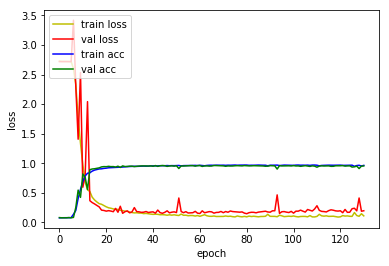

4815/4815 [==============================] - 5s 987us/sample - loss: 0.2081 - acc: 0.9475
Loss: 0.2080932543262441 Accuracy: 0.9474559

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7290 - acc: 0.0788
Epoch 00001: val_loss improved from inf to 2.71923, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_8_conv_checkpoint/001-2.7192.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 2.7290 - acc: 0.0788 - val_loss: 2.7192 - val_acc: 0.0811
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7224 - acc: 0.0800
Epoch 00002: val_loss improved from 2.71923 to 2.71905, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_8_conv_checkpoint/002-2.7190.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7224 - acc: 0.0800 - val_loss: 2.7190 - val_acc: 0.0776
Epoch 3/500
36800/36805 [======================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0793
Epoch 00027: val_loss did not improve from 2.71841
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7205 - acc: 0.0793 - val_loss: 2.7189 - val_acc: 0.0820
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0811
Epoch 00028: val_loss did not improve from 2.71841
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7205 - acc: 0.0810 - val_loss: 2.7185 - val_acc: 0.0820
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7206 - acc: 0.0800
Epoch 00029: val_loss did not improve from 2.71841
36805/36805 [==============================] - 87s 2ms/sample - loss: 2.7206 - acc: 0.0800 - val_loss: 2.7189 - val_acc: 0.0776
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0798
Epoch 00030: val_loss did not improve from 2.71841
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0796
Epoch 00056: val_loss did not improve from 2.71823
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7205 - acc: 0.0796 - val_loss: 2.7188 - val_acc: 0.0820
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7204 - acc: 0.0811
Epoch 00057: val_loss did not improve from 2.71823
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7204 - acc: 0.0811 - val_loss: 2.7186 - val_acc: 0.0818
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7204 - acc: 0.0783
Epoch 00058: val_loss did not improve from 2.71823
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7204 - acc: 0.0783 - val_loss: 2.7187 - val_acc: 0.0736
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0792
Epoch 00059: val_loss did not improve from 2.71823
36805/36805 [===========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0792
Epoch 00086: val_loss did not improve from 2.71823
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7205 - acc: 0.0792 - val_loss: 2.7190 - val_acc: 0.0820
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0799
Epoch 00087: val_loss did not improve from 2.71823
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7205 - acc: 0.0799 - val_loss: 2.7187 - val_acc: 0.0820
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7206 - acc: 0.0816
Epoch 00088: val_loss did not improve from 2.71823
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7206 - acc: 0.0816 - val_loss: 2.7185 - val_acc: 0.0820
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0800
Epoch 00089: val_loss did not improve from 2.71823
36805/36805 [===========

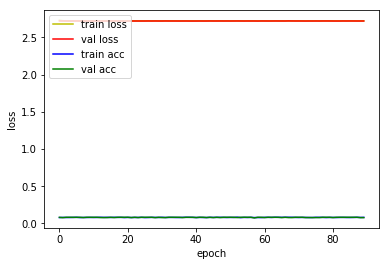

4815/4815 [==============================] - 5s 1ms/sample - loss: 2.7128 - acc: 0.0781
Loss: 2.7127533008500175 Accuracy: 0.078089304

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7284 - acc: 0.0782
Epoch 00001: val_loss improved from inf to 2.71909, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_9_conv_checkpoint/001-2.7191.hdf5
36805/36805 [==============================] - 97s 3ms/sample - loss: 2.7284 - acc: 0.0782 - val_loss: 2.7191 - val_acc: 0.0820
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7221 - acc: 0.0821
Epoch 00002: val_loss did not improve from 2.71909
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7221 - acc: 0.0821 - val_loss: 2.7192 - val_acc: 0.0785
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7211 - acc: 0.0815
Epoch 00003: val_loss improved from 2.71909 to 2.71882, saving

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0816
Epoch 00028: val_loss did not improve from 2.71831
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7205 - acc: 0.0816 - val_loss: 2.7187 - val_acc: 0.0820
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7206 - acc: 0.0796
Epoch 00029: val_loss did not improve from 2.71831
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7206 - acc: 0.0796 - val_loss: 2.7185 - val_acc: 0.0818
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0790
Epoch 00030: val_loss did not improve from 2.71831
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7205 - acc: 0.0790 - val_loss: 2.7186 - val_acc: 0.0785
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0811
Epoch 00031: val_loss did not improve from 2.71831
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0808
Epoch 00057: val_loss did not improve from 2.71825
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7205 - acc: 0.0808 - val_loss: 2.7186 - val_acc: 0.0785
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0795
Epoch 00058: val_loss did not improve from 2.71825
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7206 - acc: 0.0795 - val_loss: 2.7184 - val_acc: 0.0820
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0805
Epoch 00059: val_loss did not improve from 2.71825
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7205 - acc: 0.0805 - val_loss: 2.7185 - val_acc: 0.0820
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0812
Epoch 00060: val_loss did not improve from 2.71825
36805/36805 [========================

Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0808
Epoch 00087: val_loss did not improve from 2.71825
36805/36805 [==============================] - 89s 2ms/sample - loss: 2.7205 - acc: 0.0808 - val_loss: 2.7185 - val_acc: 0.0785
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7204 - acc: 0.0824
Epoch 00088: val_loss did not improve from 2.71825
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7205 - acc: 0.0825 - val_loss: 2.7185 - val_acc: 0.0818
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7204 - acc: 0.0791
Epoch 00089: val_loss did not improve from 2.71825
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7204 - acc: 0.0791 - val_loss: 2.7191 - val_acc: 0.0820
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7205 - acc: 0.0821
Epoch 00090: val_loss did not improve from 2.71825
36805/36805 [===========

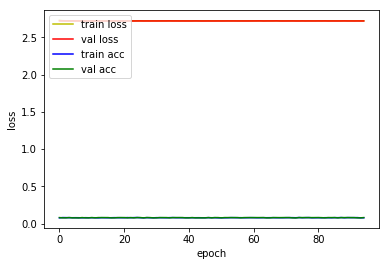

4815/4815 [==============================] - 5s 1ms/sample - loss: 2.7129 - acc: 0.0847
Loss: 2.7128722543409434 Accuracy: 0.0847352



In [10]:
base = '1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD'

for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_075_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer=SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
                  metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_95 (Conv1D)     

4815/4815 [==============================] - 5s 1ms/sample - loss: 2.7130 - acc: 0.0781
Loss: 2.7129934609493365 Accuracy: 0.078089304

1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_126 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_130 (Conv1D) 

4815/4815 [==============================] - 5s 1ms/sample - loss: 2.7129 - acc: 0.0847
Loss: 2.7128722543409434 Accuracy: 0.0847352


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_conv_3_VGG_DO_075_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_95 (Conv1D)     

4815/4815 [==============================] - 5s 1ms/sample - loss: 2.7131 - acc: 0.0800
Loss: 2.713131129382679 Accuracy: 0.07995846

1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_126 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_130 (Conv1D)   

4815/4815 [==============================] - 5s 1ms/sample - loss: 2.7132 - acc: 0.0800
Loss: 2.7131908941120373 Accuracy: 0.07995846
